# Non-linear system identification via $\ell^1$ regression

In this notebook, we look at how $\ell^1$ regularised regression can be used for identifying nonlinear dynamical systems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()
np.random.seed(5206)

## Load dataset

We will study here the spread of epidemics. 

The dataset consists of normalised periodic counts of individuals in a community, classified into three categories
- Susceptible
- Infected
- Recovered (or removed)

The data is in the form of time series for different epidemic occurences

In [2]:
data = np.load("./data/p2_sir_data.npy")
data.shape

(16, 100, 3)

The data is arranged as follows
- The first dimension is the occurences
- The second dimension is the time steps
- The last dimension are the Susceptible (S), Infected (I) and Recovered (R) (normalised) counts

In [3]:
T_max = 10  # terminal time
num_occur = data.shape[0]  # number of occurences
num_timesteps = data.shape[1]  # number of time steps
t = np.linspace(0, T_max, num_timesteps)  # time steps
dt = t[1] - t[0]  # time step size

Let us visualise some example trajectories of the epidemics

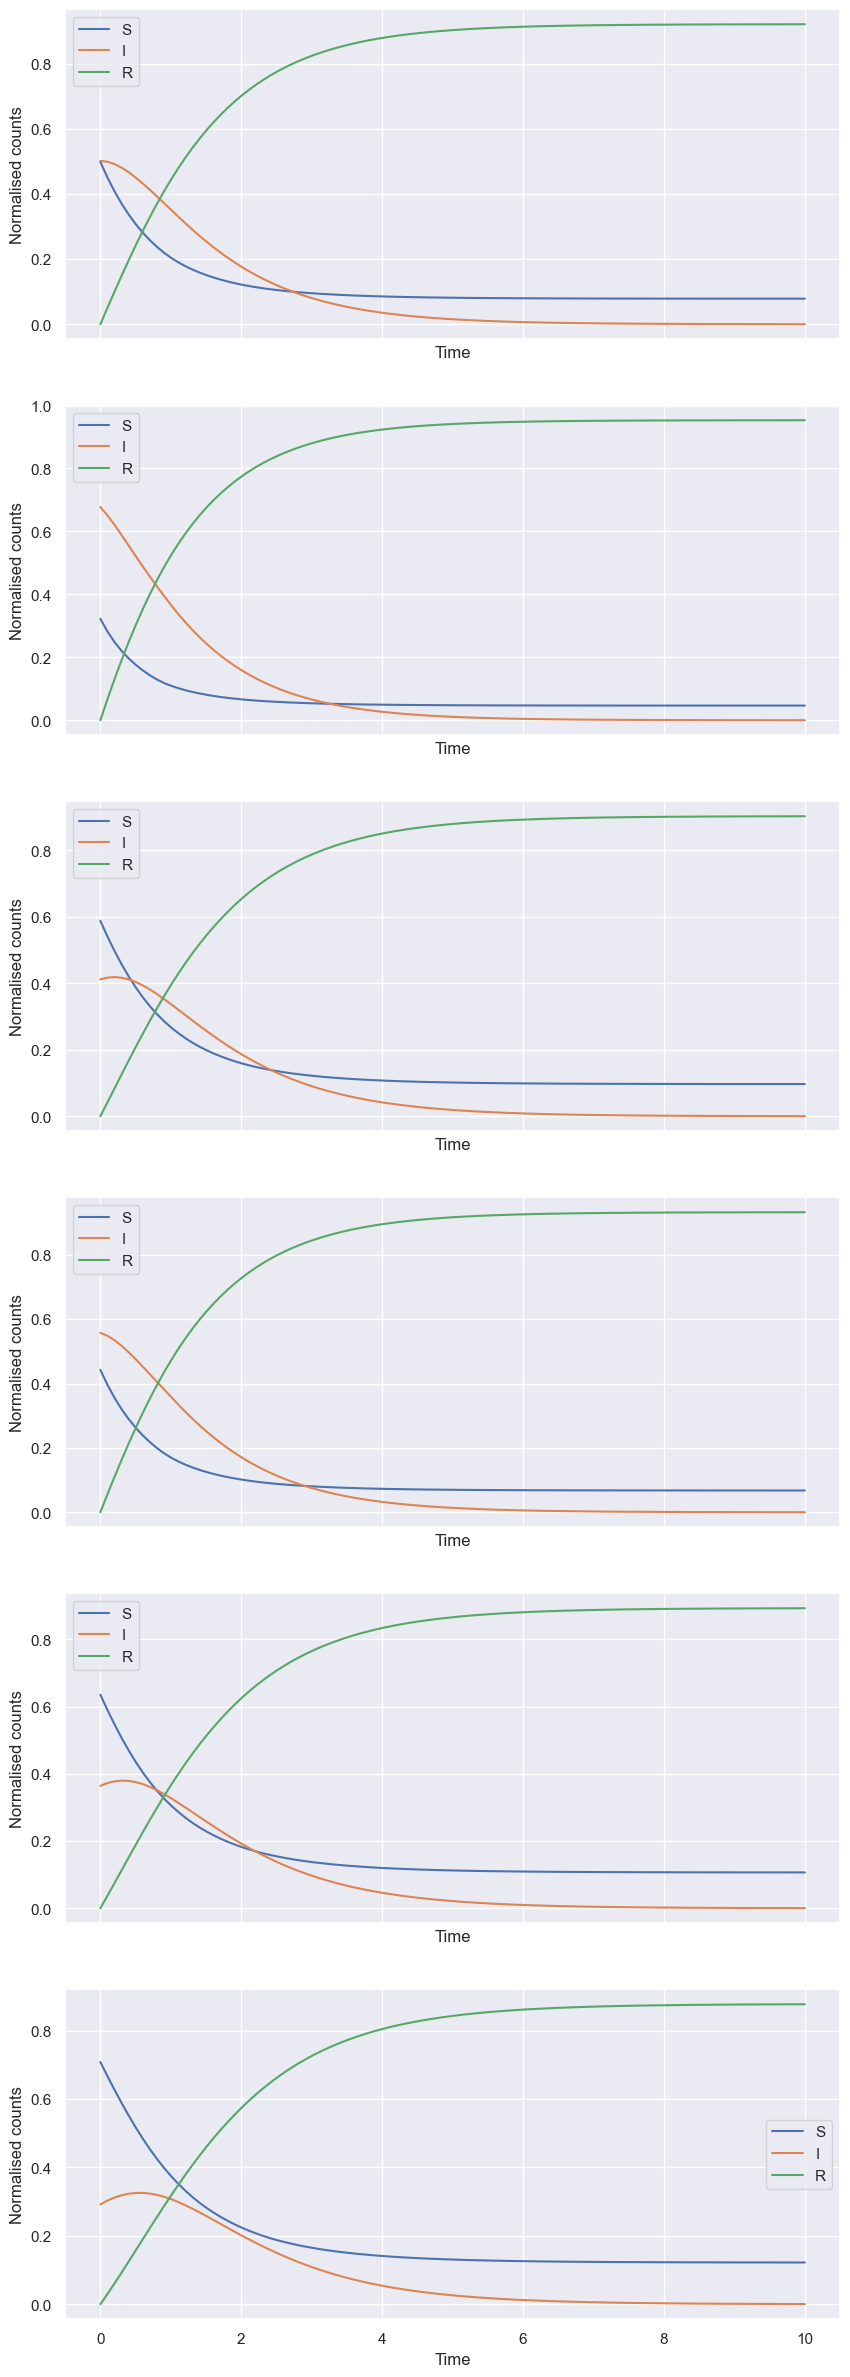

In [4]:
num_plots = 6

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5*num_plots), sharex=True)

for i in range(num_plots):

    axs[i].plot(t, data[i, :, 0], label="S")
    axs[i].plot(t, data[i, :, 1], label="I")
    axs[i].plot(t, data[i, :, 2], label="R")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Normalised counts")
    axs[i].legend()

As observed, the dynamics of S, I and R have some non-trivial inter-dependences.

Thus, we will undertake the task of identifying a differential equation type model
for their dynamics, i.e.
$$
    \begin{aligned}
        \dot{S} &= f_S(S, I, R) \\
        \dot{I} &= f_I(S, I, R) \\
        \dot{R} &= f_R(S, I, R)
    \end{aligned}
$$

## Non-linear identifcation using ridge regression

We begin by performing nonlinear identification using ridge regression. 

Write $f(S, I, R) = (f_S, f_I, f_R)^\top$. We first write each component of $f$ as a linear combination of non-linear basis functions, e.g.
$$
    f_S(S, I, R) = \sum_{j} \theta_j \varphi_j(S, I, R)
$$
A popular choice, especially for sufficiently low dimensional problems, is the polynomial basis, i.e. each $\varphi_j(S,I,R)$ is a polynomial in the variables $S, I, R$.

We can define these basis features using `sklearn.preprocessing.PolynomialFeatures`

In [5]:
from sklearn.preprocessing import PolynomialFeatures

In the following we use $x$ to denote $(S, I, R)^\top$

Essentially, we wish to fit a linear relationship between the input data $\varphi(x)$ and the output data $\frac{dx}{dt}$

In [6]:
dxdt = np.diff(data, axis=1) / dt  # compute derivative
x = data[:, :-1, :]  # remove last time step

y = dxdt.reshape(-1, 3)  # outputs
x = x.reshape(-1, 3)  # inputs (not transformed)

We now transform the inputs using the polynomial features

In [7]:
poly = PolynomialFeatures(degree=3, interaction_only=True)
phi = poly.fit_transform(x)

poly.feature_names_in_ = ['S', 'I', 'R']  # set feature names for easier interpretation

x.shape, phi.shape

((1584, 3), (1584, 8))

We first fit this relationship using a ridge regression, which penalises the $\ell^2$ norm of $\theta$

In [8]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1e-3).fit(phi, y)
ridge.score(phi, y)

0.999748697315825

Let us interpret the coefficients

In [9]:
import pandas as pd

In [10]:
coefficients = pd.DataFrame(ridge.coef_, columns=poly.get_feature_names_out(), index=['S', 'I', 'R'])
coefficients.round(2)

,1,S,I,R,S I,S R,I R,S I R
S,0.0,-0.02,0.03,-0.01,-1.98,0.01,-0.06,0.03
I,0.0,0.34,-0.66,0.33,1.88,-0.01,0.05,-0.03
R,0.0,-0.32,0.63,-0.32,0.10,-0.00,0.01,-0.01


We observe that while the fit is great, the coefficients are all over the place, and it is hard to figure out what is going on with the dynamics!

## Non-linear system identification with lasso

This time, let us repeat the regression, but instead of $\ell^2$ (ridge) regression, we will use $\ell^1$ (lasso) regression to enforce some sparsity

In [11]:
from sklearn.linear_model import Lasso

In [12]:
lasso = Lasso(alpha=1e-5).fit(phi, y)
lasso.score(phi, y)

0.9995668457358683

The fitting is again very good, and let us look at the coefficients

In [13]:
coefficients = pd.DataFrame(lasso.coef_, columns=poly.get_feature_names_out(), index=['S', 'I', 'R'])
coefficients.round(2)

,1,S,I,R,S I,S R,I R,S I R
S,0.0,-0.01,0.01,-0.0,-1.89,0.0,-0.0,-0.0
I,0.0,0.01,-0.96,0.0,1.80,-0.0,0.0,0.0
R,0.0,-0.00,0.95,-0.0,0.07,-0.0,-0.0,0.0


In fact, this suggests the following simple identified model
$$
    \begin{aligned}
        \dot{S} &= - r S I \\
        \dot{I} &=  r S I - \beta I\\
        \dot{R} &= \beta I
    \end{aligned}
$$
where $r \approx 1.85$ and $\beta \approx 0.955$

In fact, this model is nothing but the celebrated SIR model for epidemics evolution

See e.g. [wiki article](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) and references therein.

Furthermore, the quantity
$$
    r_0 = \frac{r \times S(0)}{\beta}
$$
is the "r-nought" value that you hear in the news during the global covid19 pandemic

## Exercise
- Play around with the regularisation coefficient `alpha` in lasso. How should we set this value in practice?
- Can you try to identify the SIR dynamics from a [real dataset](https://www.kaggle.com/code/lisphilar/covid-19-data-with-sir-model)?
